# Learning networks in mouse S1

#### Thanks to Nick Sofroniew and Karel Svoboda for all data, experimental parameters, and `def`'ed and `helper.plots` helper functions

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')

In [3]:
import covdict
import json
import numpy as np
import os
import pandas as pd
import scipy.stats as st
import time
from IPython.html import widgets
from helper.plots import smoothfit, tuning # https://github.com/sofroniewn/sofroniew-vlasov-2015/tree/master/helper
from sklearn.linear_model import LinearRegression as LR
from sklearn.preprocessing import scale

## Helper functions for loading and processing data

#### From https://github.com/sofroniewn/sofroniew-vlasov-2015/blob/master/imagingTable.ipynb

In [4]:
def align(table, primary, index):
    table['sourceId'] = primary['sourceId']
    table.set_index(index, inplace = True)
    table.columns = table.columns.astype('float')
    return table

In [5]:
def load(session):
    
    # Load metadata
    with open(os.path.join(path, 'data', session, 'info.json')) as infile:
        info = json.load(infile)
        
    d = {}

    # Load the units (which have our primary keys)
    d['units'] = pd.DataFrame.from_csv(os.path.join(path, 'data', session, 'tables', 'units.csv'))
    d['units']['sourceId'] = d['units'].index
    
    # Load tables    
    d['tuning'] = pd.DataFrame.from_csv(os.path.join(path, 'data', session, 'tables', 'tuning.csv'))   
    d['tuning'] = align(d['tuning'], d['units'], ['sourceId', 'label'])
    d['tuningNum'] = d['tuning'].xs('numTrials', level='label')
    err = d['tuning'].xs('stdRate', level='label').divide(d['tuningNum'].apply(np.sqrt))
    d['tuning'] = d['tuning'].xs('meanRate', level='label')
    d['tuningErr'] = err
    d['tuningSummary'] = summarize_tuning(d['tuning'])
  
    d['units'] = d['units'].drop(['sourceId'], axis=1)
    
    # Add tables
    d = pd.concat([d[x] for x in d.keys()], axis = 1, keys = d.keys())
    
    info['contributors'] = ', '.join(info['contributors'])
    info['dimensions'] = str(info['dimensions'])
    info['session'] = session
    info = pd.DataFrame(info, index = [str(info['id'])])
    
    return d, info

In [6]:
smooth = 1

def summarize_tuning(df):
    x = df.columns.values
    xs, ys = smoothfit(x, df.values[0], smooth=smooth)
    smoothed = [smoothfit(x, y, smooth=smooth)[1] for y in df.values]

    summary = pd.DataFrame(index=df.index)
    summary['Baseline'] = [y[-1] for y in smoothed]
    summary['Max'] = [max(y) for y in smoothed]
    summary['ArgMax'] = [xs[np.argmax(y)] for y in smoothed]
    summary['Min'] = [min(y) for y in smoothed]
    summary['Mean'] = [np.mean(y) for y in smoothed]

    summary['Activation'] = summary.Max - summary.Baseline
    summary['Supression'] = summary.Baseline - summary.Min
    summary['Range'] = summary.Max - summary.Min
    summary['Modulation'] = (summary.Activation - summary.Supression) / (summary.Activation + summary.Supression)
    summary['TotalModulation'] = (summary.Max - summary.Min) / (summary.Max + summary.Min)
    return summary

## Load data and summarize info

#### Cloned from https://github.com/sofroniewn/sofroniew-vlasov-2015

In [8]:
# path = '/Users/fannjiangc/code/sofroniew-vlasov-2015/'
path = '/Users/ClaraFannjiang/code/sofroniew-vlasov-2015'
session = 13 # animal ID
data = load('%02g' % session)
table = data[0]
info = data[1]
hz = info['rate-hz'][0] # sampling frequency

#### Metadata

In [9]:
info

,animal,animal-state,contributors,date,depth-microns,dimensions,experiment,id,indicator,lab,location,method,pixels-per-micron,rate-hz,region,session
Anm_0216166,Mouse,Awake head-fixed,Nicholas Sofroniew,2013_07_17,200,"[512, 512, 9606]",Tactile Virtual Reality,Anm_0216166,GCaMP6s,Svoboda Lab,Janelia Research Campus,Two-photon raster,1.15,7.1,vS1,13


#### Load behavioral covariates and time series per neuron

In [10]:
covariates = pd.DataFrame.from_csv(os.path.join(path,'data', str(session), 'params', 'covariates.csv'))
timeseries = pd.DataFrame.from_csv(os.path.join(path,'data', str(session), 'sources', 'timeseries.csv'))

## Identify tuned and active neurons

#### Fractions of tuned and active neurons

In [11]:
units = table.units.reset_index()
tuned = units.pVal < 0.05
active = units.activity > np.percentile(units.activity, 80)

summary = pd.DataFrame([sum((~active) & (~tuned)), sum(tuned), sum(active & (~tuned))], 
                               index=['inactive','tuned','untuned'], columns=['number'])
summary['frac'] = 100 * summary.number / summary.number.sum()
print summary

          number       frac
inactive     144  39.452055
tuned        191  52.328767
untuned       30   8.219178


#### Keep only active neurons

In [12]:
table_active = table[active.values]
ts = timeseries.loc[active, :].values
n = sum(active) # number of active neurons
n_samp = ts.shape[1] # number of samples

#### Plot activity per neuron

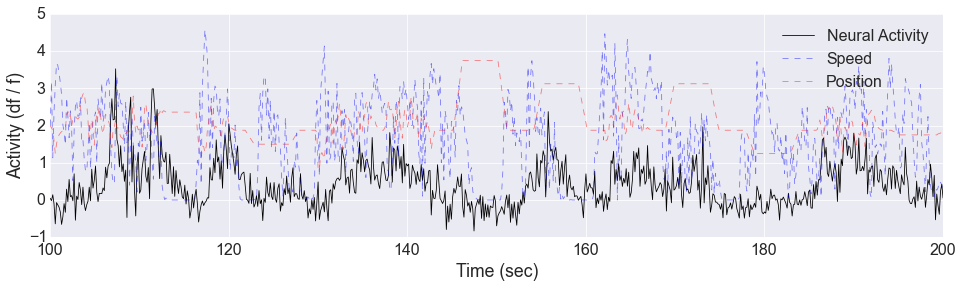

In [13]:
# Time window to view
start = 100
stop = 200

def disp(neuron):
    sns.set_style('darkgrid');
    plt.figure(figsize=(16, 4));
    x = np.arange(n_samp) / hz
    plt.plot(x, ts[neuron, :], c='k', linewidth=0.8);
    plt.xlabel('Time (sec)');
    plt.ylabel('Activity (df / f)');
    
    plt.plot(x, covariates.speed / 16, '--b', alpha=0.5, linewidth=0.8);
    plt.plot(x, covariates.corPos / 8, '--r', alpha=0.5, linewidth=0.8);
    plt.xlim(start, stop);
    plt.ylim(-1, 5);
    plt.legend(['Neural Activity', 'Speed', 'Position']);
    
widgets.interact(disp, neuron = (0, n - 1, 1));

## Learn covariance dictionary using ADMM

#### Compute sample covariance over time

In [29]:
win = int(np.max([n + 1, 2 * hz])) # time window should be at least as many samples as neurons
shift = 0.5
X = np.dstack([np.cov(ts[:, i : i + win]) for i in np.arange(0, n_samp - win, shift * win)])
# X = np.vstack([np.cov(ts[:, i : i + win])[np.triu_indices(n)] for i in range(n_samp - win)]).T
n_win = X.shape[2]

#### Run ADMM

In [30]:
k = 6 # number of dictionary elements
admm = covdict.CovarianceDictionary(k=k, method='admm', verbose=True, time=True, admm_gamma=0.5)
t = time.time()
Wadmm = admm.fit_transform(X)
print str(time.time() - t) + ' seconds'

Iter: 0. Objective: 0.988995.
Iter: 100. Objective: 0.732006.
Iter: 200. Objective: 0.726934.
Iter: 261. Objective: 0.725339.
10.3599219322 seconds


#### Plot objective per iteration

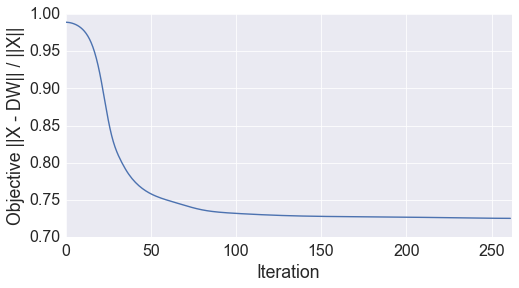

In [31]:
sns.set_style('darkgrid');
plt.figure(figsize=(8, 4));
plt.plot(admm.objective);
plt.xlim(0, admm.objective.size);
plt.xlabel('Iteration');
plt.ylabel('Objective ||X - DW|| / ||X||');

#### Compute average covariate values per time window

In [32]:
reg_names = ['xSpeed', 'ySpeed', 'corPos']
names = ['X speed', 'Y speed', 'Corr. pos.'] # regressor names for plot labels
reg_idx = [np.where(name == covariates.keys())[0][0] for name in reg_names]
n_reg = len(reg_names)

# Average over time windows
regressors = np.vstack([np.mean(covariates.loc[i : i + win, :], axis=0) 
                        for i in np.arange(0, n_samp - win, shift * win)])
reg = regressors[:, reg_idx]

# Original values (no averaging / smoothing)
# regressors = covariates.loc[: n_samp - win - 1].values
# reg = regressors[:, reg_idx].astype(float)

#### Plot dictionary weights over time with covariates

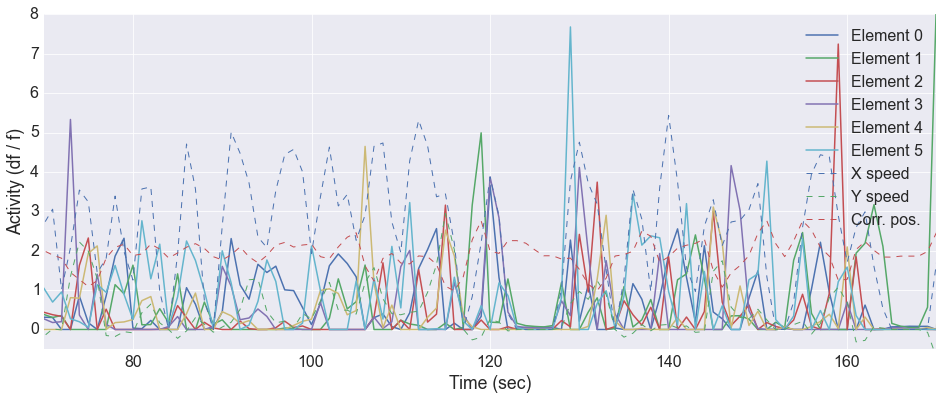

In [33]:
view = 100 # width of time window to view

def disp(start):
    sns.set_style('darkgrid')
    plt.figure(figsize=(16, 6));
    plt.plot(Wadmm.T, linewidth=1.5);
    plt.plot(reg / 8, '--', linewidth=1);    
    plt.xlabel('Time (sec)');
    plt.ylabel('Activity (df / f)');
    plt.xlim(start, start + view);
    plt.ylim(-0.5, 8);
    plt.legend(['Element ' + str(i) for i in range(k)] + names);
    
widgets.interact(disp, start = (0, n_win - view, view / 10));

#### Visualize dictionary elements

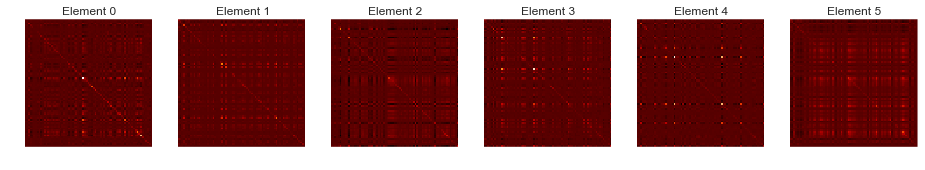

In [34]:
sns.set(rc={'axes.grid':'off', 'figure.facecolor':'white'})
plt.figure(figsize=(16, 4))

vmin = np.min(admm.dictionary)
vmax = np.max(admm.dictionary)

for i in range(k):
    plt.subplot(1, k, i + 1)   
    plt.imshow(admm.dictionary.T[i], interpolation='None', cmap='gist_heat', vmin=vmin, vmax=vmax);
    plt.title('Element ' + str(i));
    plt.axis('off');

## Are the individual tuning and network importance of a neuron related?

#### Linear regression of weights on covariates

In [35]:
lr = LR(fit_intercept=True, normalize=False).fit(scale(reg, axis=0), Wadmm.T)
coef = lr.coef_
icp = lr.intercept_

#### Plot regression coefficients

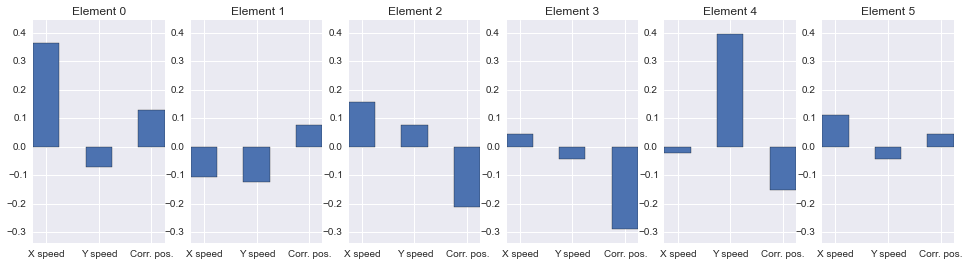

In [36]:
sns.set_style('darkgrid')
plt.figure(figsize=(5.5 * n_reg, 4));

ymin = np.min(coef) - 0.05
ymax = np.max(coef) + 0.05
width = 0.5

for i in range(k):
    plt.subplot(1, k, i + 1);
    plt.title('Element ' + str(i));
    plt.bar(np.arange(n_reg), coef[i, :], width=width);
    plt.xticks(np.arange(n_reg) + width / 2, names);
    plt.ylim(ymin, ymax);

#### Correlation between weights and covariates (simpler model)

In [37]:
cor = np.corrcoef(reg.T, Wadmm)[: n_reg, n_reg :]

#### Plot correlation coefficients

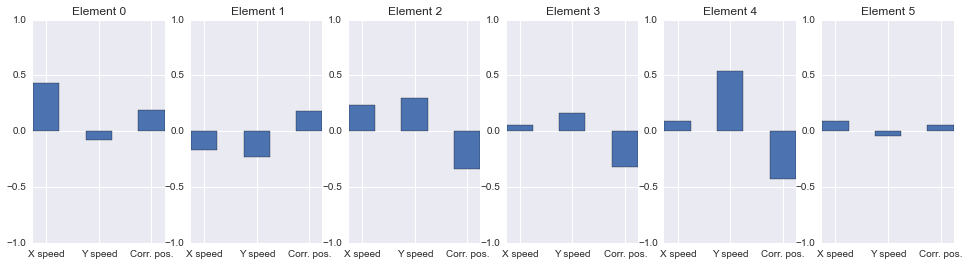

In [38]:
sns.set_style('darkgrid')
plt.figure(figsize=(5.5 * n_reg, 4)); 

for i in range(k):
    plt.subplot(1, k, i + 1);
    plt.title('Element ' + str(i));
    plt.bar(np.arange(n_reg), cor[:, i], width=width);
    plt.xticks(np.arange(n_reg) + width / 2, names);
    plt.ylim(-1, 1);

#### Quantify importance of each neuron in each dictionary element
This measures how much removing a neuron changes the network in the Frobenius norm sense. Other metric?

In [39]:
strength = [np.sum(elem ** 2, axis=0) / np.sum(elem ** 2) for elem in admm.dictionary.T]

AttributeError: 'module' object has no attribute 'reform'

#### Corridor position tuning selectivity of each neuron

In [243]:
# p_tune = table_active.units.pVal.values 
tune = np.std(table_active.tuning.values, axis=1) # variation in tuning curve reflects selectivity

#### Linear regression between network importance and tuning selectivity

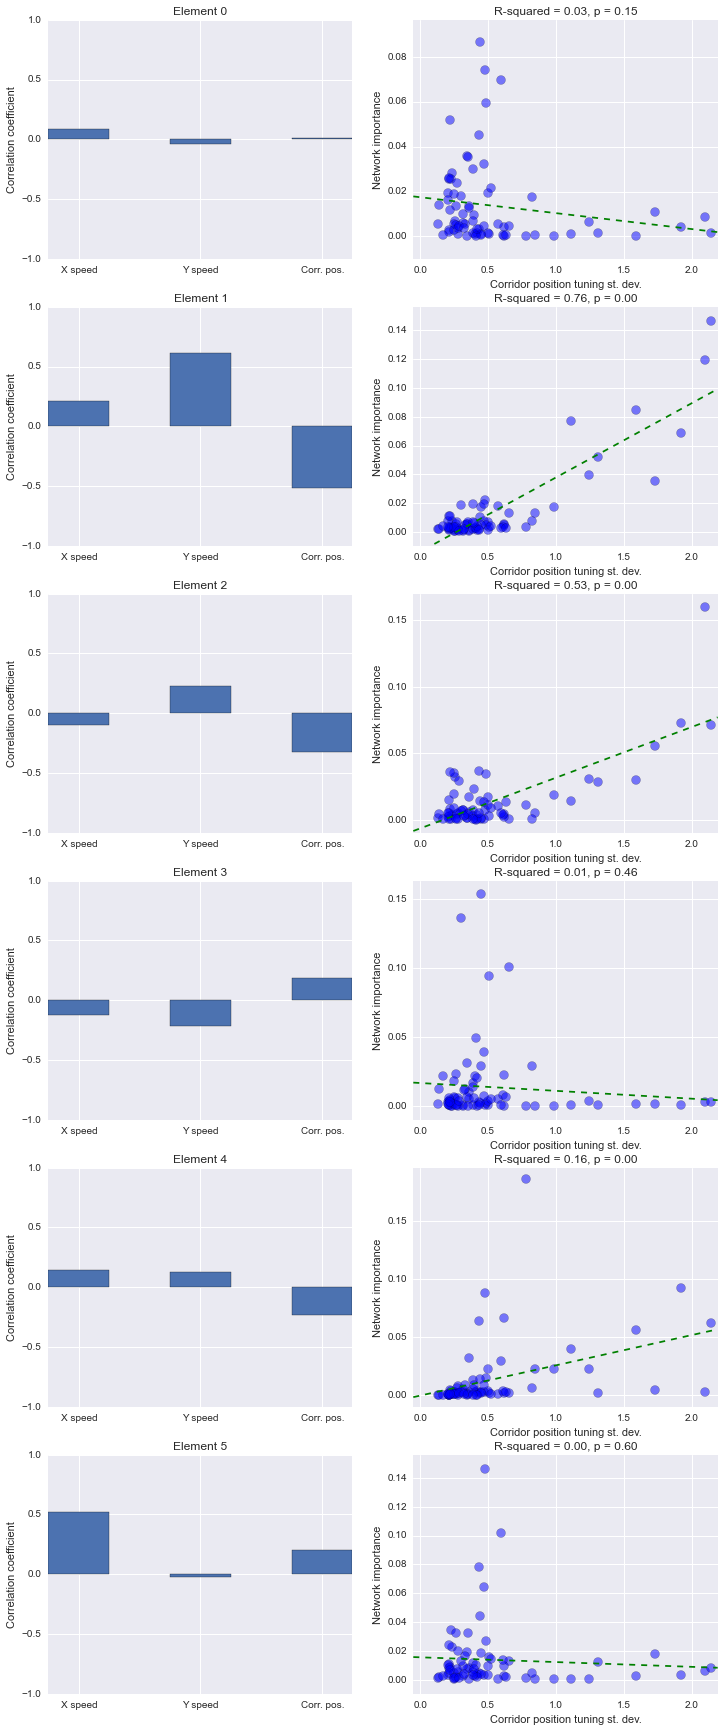

In [244]:
plt.figure(figsize=(12, 5 * k));

xmin = -0.05
xmax = np.max(tune) + 0.05
x = [xmin, xmax]
slope = np.empty(k)
rsqu = np.empty(k)
p_slope = np.empty(k)
 
for i in range(k):
    
    # Plot correlations to behavioral covariates for reference.
    # Note any relationship between correlation to corPos and
    # network importance of highly tuned neurons
    plt.subplot(k, 2, 2 * i + 1);
    plt.bar(np.arange(n_reg), cor[:, i], width=width);
    plt.xticks(np.arange(n_reg) + width / 2, names);
    plt.ylim(-1, 1);
    plt.ylabel('Correlation coefficient');
    plt.title('Element ' + str(i));
    
    # Plot network influence by tuning selectivity
    plt.subplot(k, 2, 2 * (i + 1)); 
    plt.scatter(tune, strength[i], s=80, alpha=0.5);
    plt.xlabel('Corridor position tuning st. dev.');
    plt.ylabel('Network importance');
    plt.xlim(xmin, xmax);
    plt.ylim(np.min(strength[i]) - 0.01, np.max(strength[i]) + 0.01);
    
    # Linear regression
    slope[i], icp, r, p_slope[i], _ = st.linregress(tune, strength[i])
    rsqu[i] = r ** 2
    y = [slope[i] * val + icp for val in x]
    plt.plot(x, y, '--g');
    plt.title('R-squared = %0.2f, p = %0.2f' % (rsqu[i], p_slope[i]));
    


#### Regression between 1) correlation with corridor position and 2) association between network influence and tuning
Shorter way to explain this?

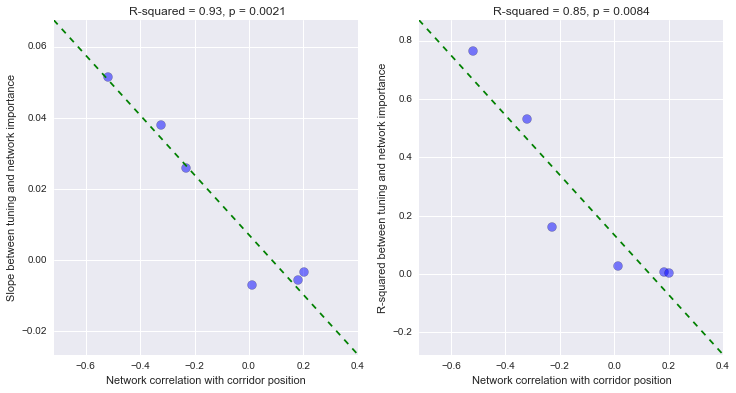

In [245]:
plt.figure(figsize=(12, 6));

# Plot network correlation with corridor position against tuning-vs.-importance slope
plt.subplot(121);
plt.scatter(cor[-1, :], slope, s=80, alpha=0.5);
plt.xlabel('Network correlation with corridor position');
plt.ylabel('Slope between tuning and network importance');

# Best-fit line
sl, ic, r, p, _ = st.linregress(cor[-1, :], slope)
x = [np.min(cor[-1, :]) - 0.2, np.max(cor[-1, :]) + 0.2]
y = [sl * val + ic for val in x]
plt.plot(x, y, '--g');
plt.xlim(x);
plt.ylim(y[::-1]);
plt.title('R-squared = %0.2f, p = %0.4f' % (r ** 2, p));

# Plot network correlation with corridor position against tuning-vs.-importance R-squared
plt.subplot(122);
plt.scatter(cor[-1, :], rsqu, s=80, alpha=0.5);
plt.xlabel('Network correlation with corridor position');
plt.ylabel('R-squared between tuning and network importance');

# Best-fit line
sl, ic, r, p, _ = st.linregress(cor[-1, :], rsqu)
x = [np.min(cor[-1, :]) - 0.2, np.max(cor[-1, :]) + 0.2]
y = [sl * val + ic for val in x]
plt.plot(x, y, '--g');
plt.xlim(x);
plt.ylim(y[::-1]);
plt.title('R-squared = %0.2f, p = %0.4f' % (r ** 2, p));

#### Identify most important neurons of network most correlated to corridor position

In [246]:
n_top = 8 # number of most important neurons to find
corpos_idx = np.argmax(abs(cor[-1, :])) # most correlated dictionary element
idx = np.argsort(strength[corpos_idx])[::-1][: n_top] # most important neurons in this dictionary element
top_idx = table_active.index[idx]

#### Plot tuning curves of most important neurons

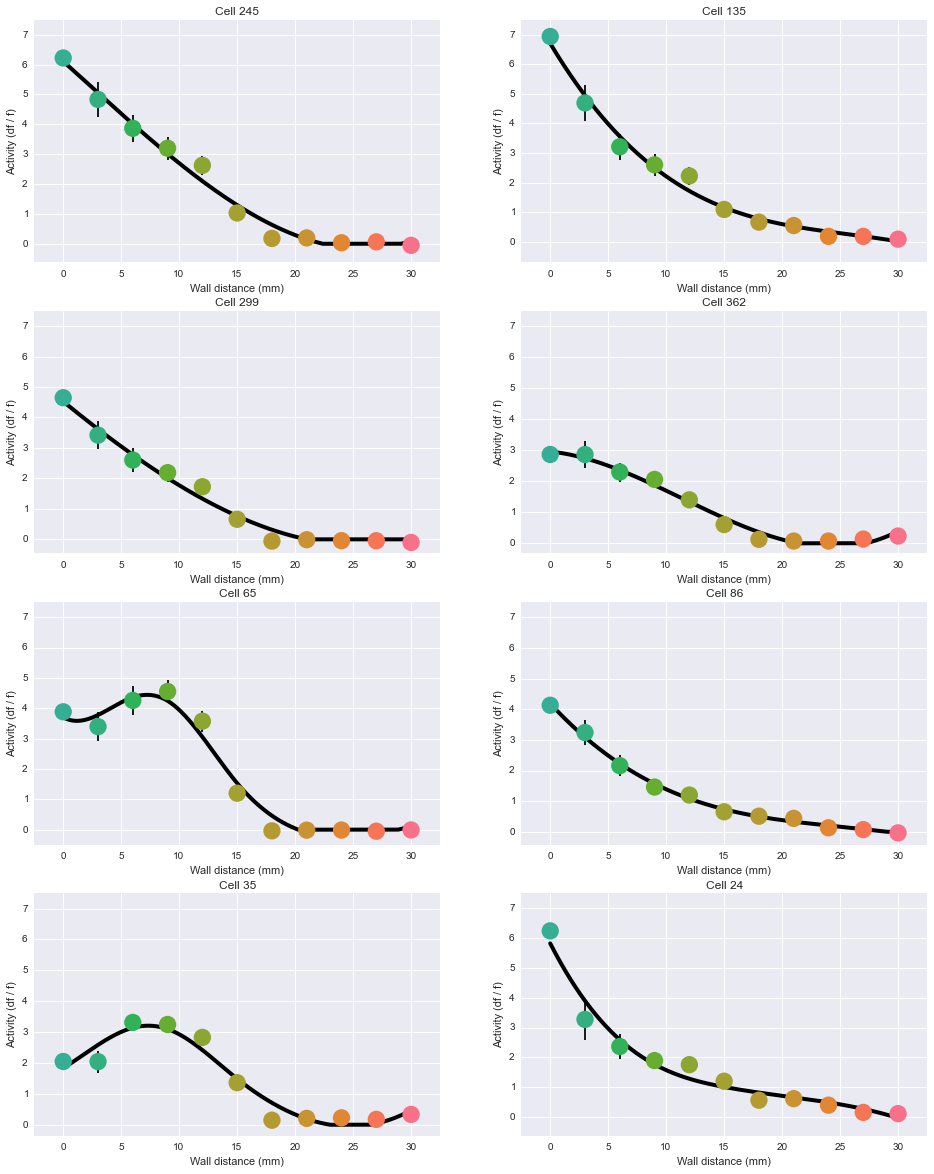

In [247]:
plt.figure(figsize=(16, 5 * n_top / 2));
x = table_active.tuning.columns.values
for i, idx in enumerate(top_idx):
    plt.subplot(np.ceil(n_top / 2), 2, i + 1);
    y = table_active.tuning.loc[idx].values
    err = table_active.tuningErr.loc[idx].values
    tuning(x, y, err, smooth=smooth, ylabel='Activity (df / f)');
    plt.ylim(plt.ylim()[0], 7.5);
    plt.title('Cell ' + str(idx));

#### Identify least important cells of network most correlated to corridor position

In [248]:
n_bot = 8 # number of least important neurons to find
idx = np.argsort(strength[corpos_idx])[: n_bot] # least important neurons in this dictionary element
bot_idx = table_active.index[idx]

#### Plot tuning curves of least important neurons

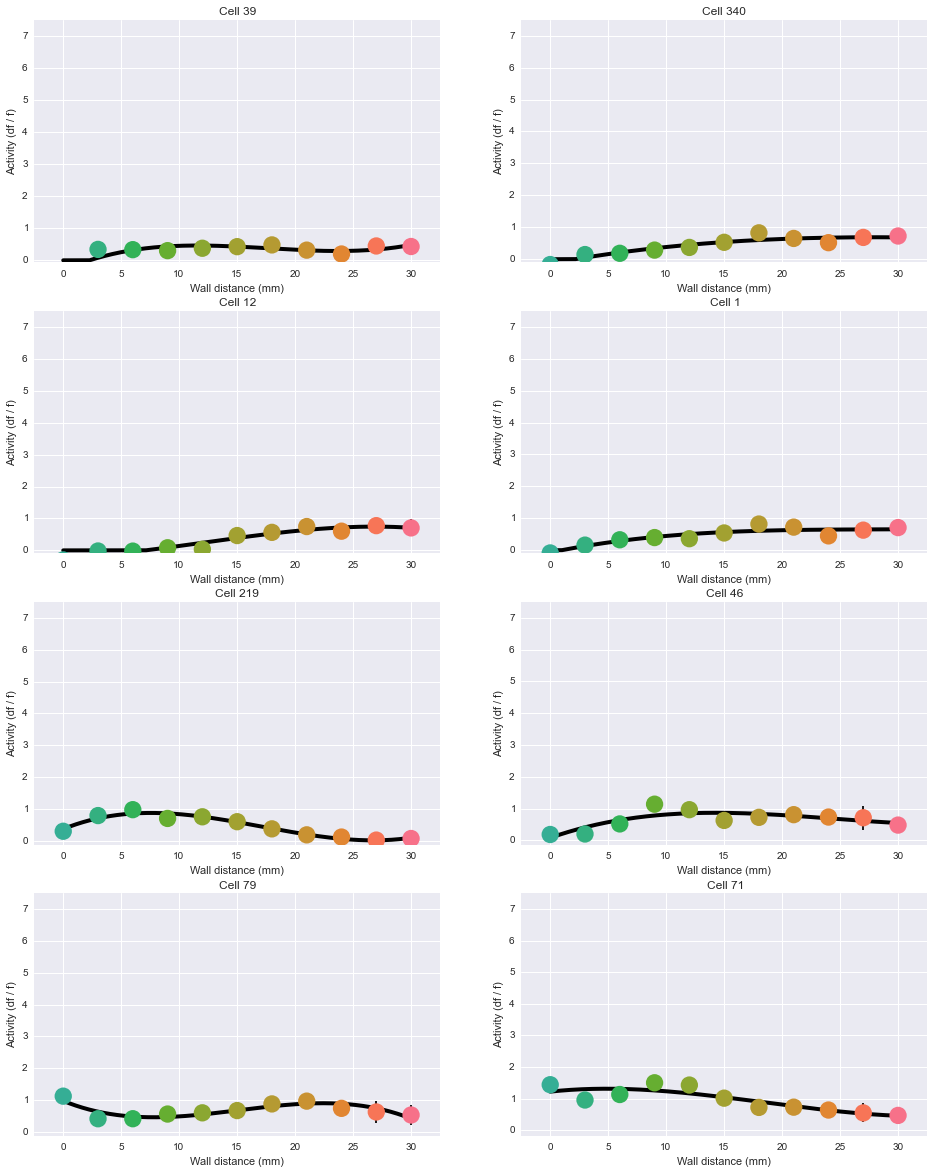

In [249]:
plt.figure(figsize=(16, 5 * n_bot / 2));
x = table_active.tuning.columns.values
for i, idx in enumerate(bot_idx):
    plt.subplot(np.ceil(n_bot / 2), 2, i + 1);
    y = table_active.tuning.loc[idx].values
    err = table_active.tuningErr.loc[idx].values
    tuning(x, y, err, smooth=smooth, ylabel='Activity (df / f)');
    plt.ylim(plt.ylim()[0], 7.5);
    plt.title('Cell ' + str(idx));